##  Data Preparation

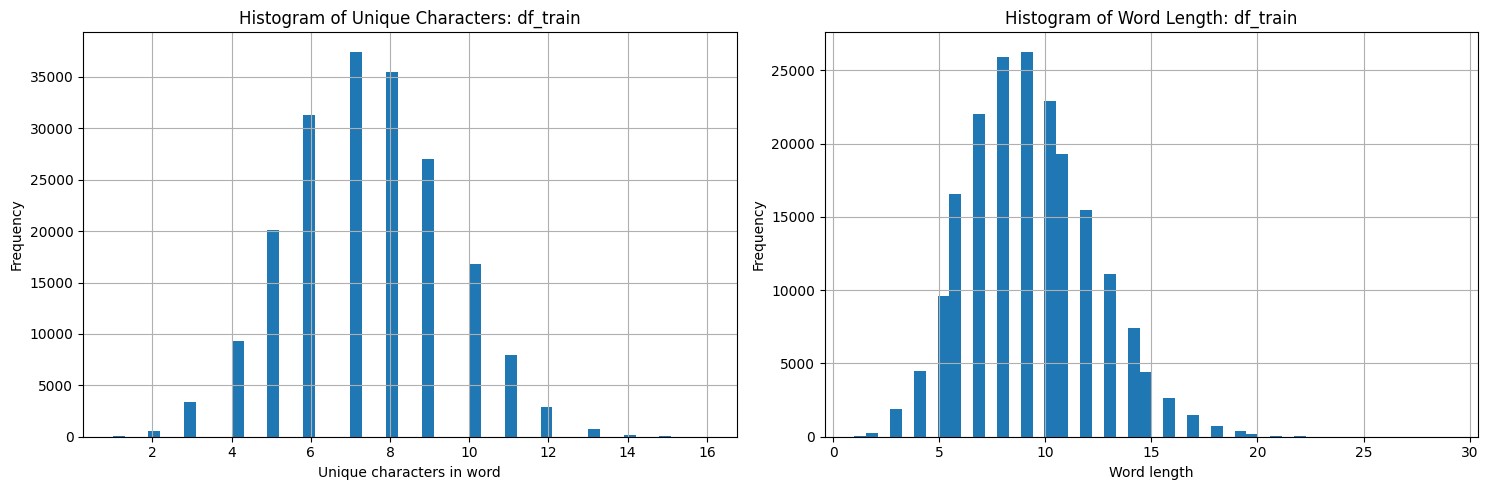

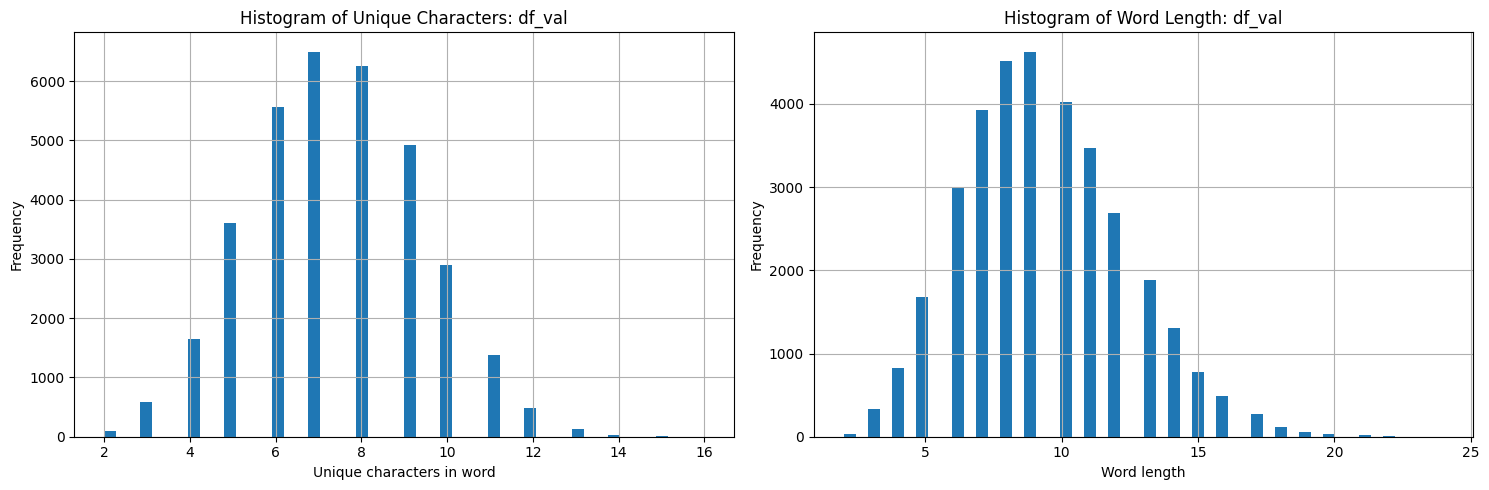

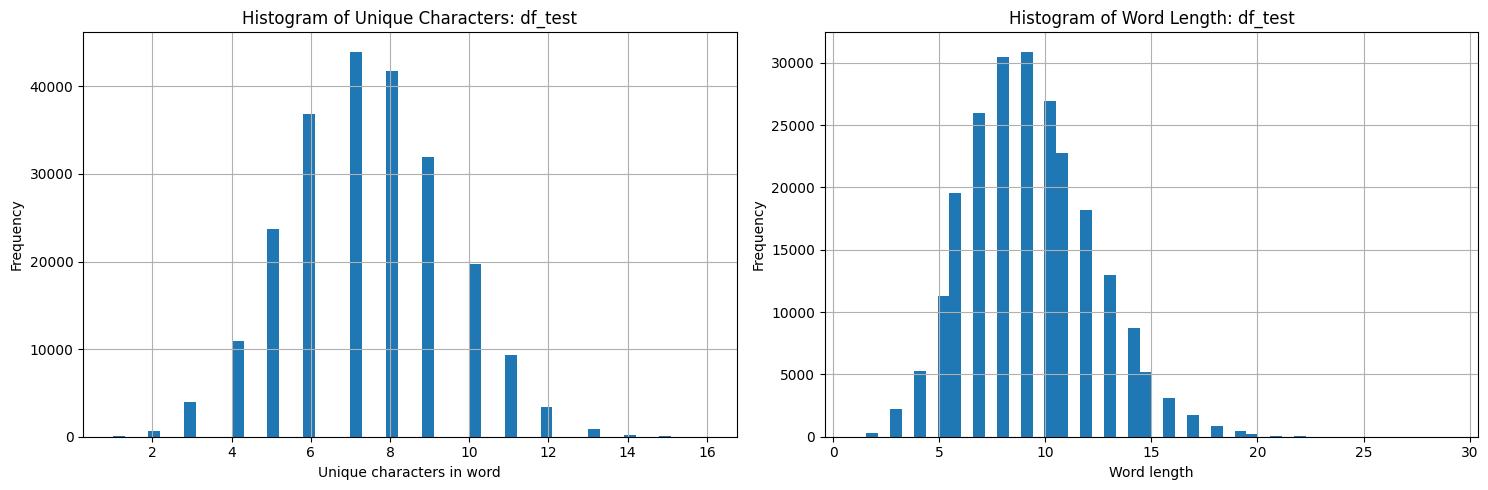

In [27]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt


# Load the dataset consider all types string
DATASETPATH = "/home/zosov/workspace/jobs/trexquant/character-bert/data/words_250000_train.txt"
TEST_DATASETPATH = "/home/zosov/workspace/jobs/trexquant/character-bert/data/words_130438_test.txt"

# No class character and number
NO_CLASS = 27
NO_CLASS_CHAR = '-'

def load_dataset(file_path):
    def load_csv_as_strings(file_path):
        with open(file_path, newline='') as csvfile:
            reader = csv.reader(csvfile)
            lines = [''.join(row) for row in reader]
        return lines

    lines = load_csv_as_strings(DATASETPATH)

    df = pd.DataFrame(lines, columns=["word"], dtype=str)

    # Get the length of each word
    df["word_length"] = df["word"].apply(len)

    # Get the unique characters in each word
    df["unique_chars"] = df["word"].apply(lambda x: len(set(x)))

    return df

# Split randomly df into train and validation sets (85% train, 15% validation)
def split_train_val(df, train_size=0.85):
    # Randomly shuffle the dataset
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)

    # Split the dataset into train and validation sets
    train_df = df.iloc[:int(train_size * len(df))]
    val_df = df.iloc[int(train_size * len(df)):]

    return train_df, val_df

# Load the dataset
df = load_dataset(DATASETPATH)
df_train, df_val = split_train_val(df,  train_size=0.85)
df_test = load_dataset(TEST_DATASETPATH)


def plot_histograms(df, title = "df_train"):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    # Plot the first histogram for unique_chars
    df["unique_chars"].hist(bins=50, ax=axs[0])
    axs[0].set_xlabel('Unique characters in word')
    axs[0].set_ylabel('Frequency')
    axs[0].set_title(f'Histogram of Unique Characters: {title}')

    # Plot the second histogram for word_length
    df["word_length"].hist(bins=50, ax=axs[1])
    axs[1].set_xlabel('Word length')
    axs[1].set_ylabel('Frequency')
    axs[1].set_title(f'Histogram of Word Length: {title}')

    plt.tight_layout()
    plt.show()

plot_histograms(df_train, title = "df_train")

plot_histograms(df_val, title = "df_val")

plot_histograms(df_test, title = "df_test")

In [58]:
# Better approach to mask the characters the unique chars in the word
# Follow a similar approach as MLM, but masking only a percentage of the characters in the word
# What percentage to use?

# For small length words <5 of unique characters
percentages = [0.6, 0.7, 0.8]

counts = []
for percentage in percentages:
    # print("word length", "number of masked characters")
    tmp_count = []
    for i in range(1, 6):
        tmp_count.append(round(i*percentage))
    counts.append(tmp_count)

print(np.array(counts))

# For larger length words >=6 of unique characters
percentages = [0.1, 0.2, 0.1, 0.2, 0.30, 0.4, 0.5, 0.6, 0.8]

counts = []
for percentage in percentages:
    # print("word length", "number of masked characters")
    tmp_count = []
    for i in range(6, 17):
        tmp_count.append(round(i*percentage))
    counts.append(tmp_count)

print(np.array(counts))

[[1 1 2 2 3]
 [1 1 2 3 4]
 [1 2 2 3 4]]
[[ 1  1  1  1  1  1  1  1  1  2  2]
 [ 1  1  2  2  2  2  2  3  3  3  3]
 [ 1  1  1  1  1  1  1  1  1  2  2]
 [ 1  1  2  2  2  2  2  3  3  3  3]
 [ 2  2  2  3  3  3  4  4  4  4  5]
 [ 2  3  3  4  4  4  5  5  6  6  6]
 [ 3  4  4  4  5  6  6  6  7  8  8]
 [ 4  4  5  5  6  7  7  8  8  9 10]
 [ 5  6  6  7  8  9 10 10 11 12 13]]


In [28]:
# NOTE: The distribution is close to a normal. Indicating most of the words have around 7 unique characters
# I gonna chose that number to mask as much as 7 characters in each word if possible with a probability of 0.75

def create_masked_words(df, percentage_masked_chars=0.65):

    # Chose a character randonmly in each word and replace each occurance with an underscore character "_" and create a new column with that masked word
    def mask_word(word, percentage_masked_chars=0.65):

        # Get the unique characters in the word
        set_word = list(set(word))

        # Choose the number of characters to mask
        n_masked_chars = round(len(set_word) * percentage_masked_chars)
        
        if n_masked_chars > len(set_word):
            n_masked_chars = len(set_word)

        idxs = np.random.choice(len(set_word), size = n_masked_chars, replace=False)

        # Mask the characters
        masked_word = word
        for i in idxs:
            char = set_word[int(i)]
            masked_word = masked_word.replace(char, "_")

        return masked_word

    df["masked_word"] = df["word"].apply(lambda x: mask_word(x, percentage_masked_chars))

    # Add an additional column with a list of the indexes of the masked characters
    def masked_char_indexes(masked_word):
        return [i for i, c in enumerate(masked_word) if c == "_"]

    df["masked_char_indexes"] = df["masked_word"].apply(masked_char_indexes)

    # Add an additional column with the labels considering the vocab size 26 (a-z)
    def masked_char_labels(masked_word, word, in_char = False):
        def get_index(char):
            return ord(char) - ord('a')
        
        if not in_char:
            labels = [NO_CLASS] * len(word)
            for i in range(len(word)):
                if masked_word[i] == "_":
                    labels[i] = get_index(word[i])
        else:
            labels = [NO_CLASS_CHAR] * len(word)
            for i in range(len(word)):
                if masked_word[i] == "_":
                    labels[i] = word[i]
        return labels

    df["labels_char"] = df.apply(lambda row: masked_char_labels(row["masked_word"], row["word"], in_char = True), axis=1)

    df["labels"] = df.apply(lambda row: masked_char_labels(row["masked_word"], row["word"]), axis=1)

    return df

def create_chunks_of_masked_words(df_input, percentages):
    df_result = None
    for percentage in percentages:
        df1 = create_masked_words(df_input, percentage_masked_chars=percentage)
 
        # Concatenate the datasets
        if df_result is None:
            df_result = df1
        else:
            df_result = pd.concat([df_result, df1])

    return df_result

def create_simulated_data(df, small_words_percentages, large_words_percentages):
    # Filter small words from df with word_len < 6
    df_small = df[df["unique_chars"] < 6].copy()

    # Calculate different datasets with different percentages of masked characters and concat them together
    df_total_small = create_chunks_of_masked_words(df_small, small_words_percentages)


    # Filter large words from df with word_len >= 6
    df_large = df[df["unique_chars"] >= 6].copy()

    # Calculate different datasets with different percentages of masked characters and concat them together
    df_total_large = create_chunks_of_masked_words(df_large, large_words_percentages)

    # Concatenate the datasets
    df_total = pd.concat([df_total_small, df_total_large])

    return df_total_small, df_total_large,  df_total


In [ ]:
_ _ _ _ _

250000 words

El potter no [MASK] novia

p _ t t e r


# 1. Filtrar las palabras
# 2. Palabras mas comunes
# 3. Data colador
# 4. Penalize more small words??
# 5. Podria concatenar las palabras adivinadas hasta ahora al final del classifier, es practicamente concatenar un one-hot vector 
# de 0-26 con 1 donde las palabras ya fueron adivinadas.
# 6. Podria usar one-hot encodings 0-27 para los characteres
# 7. El Test y el val tambien generalo de manera dinamica. No te preocupes por que distribucion tendra.


In [1]:
import random
import torch
from transformers import DataCollatorForLanguageModeling, BertTokenizer

class CustomDataCollatorForMLM(DataCollatorForLanguageModeling):
    def __init__(self, tokenizer, mlm_probability=0.15):
        super().__init__(tokenizer=tokenizer, mlm_probability=mlm_probability)
    
    def __call__(self, examples):
        # Tokenize and pad the input examples
        batch = self.tokenizer(examples, padding=True, truncation=True, return_tensors="pt")
        
        # Get the input_ids and apply masking
        input_ids = batch["input_ids"]
        labels = input_ids.clone()
        
        # Create a mask array of the same shape as input_ids
        probability_matrix = torch.full(labels.shape, self.mlm_probability)
        special_tokens_mask = [
            self.tokenizer.get_special_tokens_mask(val, already_has_special_tokens=True) for val in labels.tolist()
        ]
        probability_matrix.masked_fill_(torch.tensor(special_tokens_mask, dtype=torch.bool), value=0.0)
        masked_indices = torch.bernoulli(probability_matrix).bool()
        
        labels[~masked_indices] = -100  # We only compute loss on masked tokens
        
        # 80% of the time, replace masked input tokens with tokenizer.mask_token ([MASK])
        indices_replaced = torch.bernoulli(torch.full(labels.shape, 0.8)).bool() & masked_indices
        input_ids[indices_replaced] = self.tokenizer.convert_tokens_to_ids(self.tokenizer.mask_token)
        
        # 10% of the time, replace masked input tokens with random word
        indices_random = torch.bernoulli(torch.full(labels.shape, 0.5)).bool() & masked_indices & ~indices_replaced
        random_words = torch.randint(len(self.tokenizer), labels.shape, dtype=torch.long)
        input_ids[indices_random] = random_words[indices_random]
        
        # The rest of the time (10% of the time) we keep the masked input tokens unchanged
        
        batch["input_ids"] = input_ids
        batch["labels"] = labels
        return batch


/home/zosov/anaconda3/envs/character-bert/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Initialize the custom data collator
data_collator = CustomDataCollatorForMLM(tokenizer)

# Sample input examples
examples = [
    "a b a d o n e d",
    "t r a y e c t o r y",
]

# Prepare a batch using the custom data collator
batch = data_collator(examples)

print(batch)


{'input_ids': tensor([[  101,  7592,  1010,  2026,  3899,  2003, 10140,   102,     0,     0,
             0],
        [  101,  1996,  4248,  2829,  4419, 14523,  2058,  1996, 13971,  3899,
           102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]), 'labels': tensor([[-100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100],
        [-100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100]])}


In [29]:
small_words_percentages = [0.6, 0.7, 0.8]
large_words_percentages = [0.1, 0.2, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8]

29

512

0.15

80 mask
10 sin nada
10 otra palabra


# Train dataset and save to a file
# df_total_small, df_total_large,  df_total = create_simulated_data(df_train, small_words_percentages, large_words_percentages)
# df_total.to_csv('data/words_train_simulated.csv', index=False)

# # Validation dataset and save to a file
# df_total_small, df_total_large,  df_total = create_simulated_data(df_val, small_words_percentages, large_words_percentages)
# df_total.to_csv('data/words_val_simulated.csv', index=False)

# # Test dataset and save to a file
# df_total_small, df_total_large,  df_total = create_simulated_data(df_test, small_words_percentages, large_words_percentages)
# df_total.to_csv('data/words_test_simulated.csv', index=False)


In [61]:
# print(df_total_small.shape)
# print(df_total_large.shape)

In [62]:
# fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# # Plot the distribution of unique chars in the masked words for df_total_small
# axs[0, 0].hist(df_total_small["masked_word"].apply(lambda x: len(set(x))), bins=50)
# axs[0, 0].set_xlabel('Word length (unique characters)')
# axs[0, 0].set_ylabel('Frequency')
# axs[0, 0].set_title('Unique chars in df_total_small masked words')

# # Plot the distribution of unique chars in the masked words for df_total_large
# axs[0, 1].hist(df_total_large["masked_word"].apply(lambda x: len(set(x))), bins=50)
# axs[0, 1].set_xlabel('Word length (unique characters)')
# axs[0, 1].set_ylabel('Frequency')
# axs[0, 1].set_title('Unique chars in df_total_large masked words')

# # Plot the distribution of unique chars in the masked words for df_total
# axs[1, 0].hist(df_total["masked_word"].apply(lambda x: len(set(x))), bins=50)
# axs[1, 0].set_xlabel('Masked unique characters')
# axs[1, 0].set_ylabel('Frequency')
# axs[1, 0].set_title('Unique chars in df_total masked words')

# # Plot the distribution of unique chars in the words for df
# axs[1, 1].hist(df["unique_chars"], bins=50)
# axs[1, 1].set_xlabel('Unique characters')
# axs[1, 1].set_ylabel('Frequency')
# axs[1, 1].set_title('Unique chars in df words')

# plt.tight_layout()
# plt.show()

In [63]:
# # Note: Repeate the same process for the test dataset
# small_words_percentages = [0.6, 0.7, 0.8]
# large_words_percentages = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8]

# # df_test_total_small, df_test_total_large,  df_test_total = create_simulated_data(df_test, small_words_percentages, large_words_percentages)

In [64]:
# fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# # Plot the distribution of unique chars in the masked words for df_total_small
# axs[0, 0].hist(df_test_total_small["masked_word"].apply(lambda x: len(set(x))), bins=50)
# axs[0, 0].set_xlabel('Word length (unique characters)')
# axs[0, 0].set_ylabel('Frequency')
# axs[0, 0].set_title('Unique chars in df_total_small masked words')

# # Plot the distribution of unique chars in the masked words for df_total_large
# axs[0, 1].hist(df_test_total_large["masked_word"].apply(lambda x: len(set(x))), bins=50)
# axs[0, 1].set_xlabel('Word length (unique characters)')
# axs[0, 1].set_ylabel('Frequency')
# axs[0, 1].set_title('Unique chars in df_total_large masked words')

# # Plot the distribution of unique chars in the masked words for df_total
# axs[1, 0].hist(df_test_total["masked_word"].apply(lambda x: len(set(x))), bins=50)
# axs[1, 0].set_xlabel('Masked unique characters')
# axs[1, 0].set_ylabel('Frequency')
# axs[1, 0].set_title('Unique chars in df_total masked words')

# # Plot the distribution of unique chars in the words for df
# axs[1, 1].hist(df_test["unique_chars"], bins=50)
# axs[1, 1].set_xlabel('Unique characters')
# axs[1, 1].set_ylabel('Frequency')
# axs[1, 1].set_title('Unique chars in df words')

# plt.tight_layout()
# plt.show()

## Load dataset in the dataloader format


In [30]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from datasets import DatasetDict, Dataset

In [31]:
# Load datasets 
df_train = pd.read_csv('data/words_train_simulated.csv')
df_val = pd.read_csv('data/words_val_simulated.csv')
df_test = pd.read_csv('data/words_test_simulated.csv')

# Define random toys dataset
# Pick randomly 250000 samples from the test dataset with a seed
df_train = df_train.sample(n=300000, random_state=42)
df_val = df_val.sample(n=50000, random_state=42)
df_test = df_test.sample(n=50000, random_state=42)

# Convert the string of labels columns to a list of integers
df_train["labels"] = df_train["labels"].apply(eval)
df_val["labels"] = df_val["labels"].apply(eval)
df_test["labels"] = df_test["labels"].apply(eval)

# Convert the string of masked_char_idx columns to a list of integers
df_train["masked_char_indexes"] = df_train["masked_char_indexes"].apply(eval)
df_val["masked_char_indexes"] = df_val["masked_char_indexes"].apply(eval)
df_test["masked_char_indexes"] = df_test["masked_char_indexes"].apply(eval)


# Print the shapes of the datasets
print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(300000, 7)
(50000, 7)


In [32]:
# Add a space to each char in each word to simulate a tokenization per char
df_train["word"] = df_train["word"].apply(lambda x: " ".join(list(str(x))))
df_train["masked_word"] = df_train["masked_word"].apply(lambda x: " ".join(list(str(x))))

# Add a space to each char in each word to simulate a tokenization per char
df_test["word"] = df_test["word"].apply(lambda x: " ".join(list(str(x))))
df_test["masked_word"] = df_test["masked_word"].apply(lambda x: " ".join(list(str(x))))

df_train.head()

,word,word_length,unique_chars,masked_word,masked_char_indexes,labels_char,labels
1346450,w h i t e b o y s,9,9,w _ _ _ _ b o y _,"[1, 2, 3, 4, 8]","['-', 'h', 'i', 't', 'e', '-', '-', '-', 's']","[27, 7, 8, 19, 4, 27, 27, 27, 18]"
745648,h e b d o m a d a r y,11,9,h e b _ _ m a _ a r _,"[3, 4, 7, 10]","['-', '-', '-', 'd', 'o', '-', '-', 'd', '-', ...","[27, 27, 27, 3, 14, 27, 27, 3, 27, 27, 24]"
947355,p o l y n o m i a l s,11,9,_ o l _ _ o m i _ l s,"[0, 3, 4, 8]","['p', '-', '-', 'y', 'n', '-', '-', '-', 'a', ...","[15, 27, 27, 24, 13, 27, 27, 27, 0, 27, 27]"
1119451,i n t r o s p e c t i v i s m,15,11,_ n t r _ _ _ _ _ t _ v _ _ m,"[0, 4, 5, 6, 7, 8, 10, 12, 13]","['i', '-', '-', '-', 'o', 's', 'p', 'e', 'c', ...","[8, 27, 27, 27, 14, 18, 15, 4, 2, 27, 8, 27, 8..."
1074655,u n w h o l e s o m e,11,9,u _ w _ o _ e s o _ e,"[1, 3, 5, 9]","['-', 'n', '-', 'h', '-', 'l', '-', '-', '-', ...","[27, 13, 27, 7, 27, 11, 27, 27, 27, 12, 27]"


In [33]:
# Gather all the data in a DatasetDict
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)

data = DatasetDict({
    "train": Dataset.from_pandas(df_train[["masked_word", "labels"]]),
    "valid": Dataset.from_pandas(df_val[["masked_word", "labels"]]),
    "test": Dataset.from_pandas(df_test[["masked_word", "labels"]])
})

data


DatasetDict({
    train: Dataset({
        features: ['masked_word', 'labels'],
        num_rows: 300000
    })
    valid: Dataset({
        features: ['masked_word', 'labels'],
        num_rows: 50000
    })
    test: Dataset({
        features: ['masked_word', 'labels'],
        num_rows: 50000
    })
})

In [5]:
# # Plot the frequency of characters in the complete dataset, train, val and test
# # To check similarities in the distribution of characters
# import matplotlib.pyplot as plt

# # Frequency of characters in the complete dataset
# char_freq = {}
# for word in df["word"]:
#     for char in word:
#         if char != " ":  # Ignore spaces
#             char_freq[char] = char_freq.get(char, 0) + 1
# char_freq = pd.Series(char_freq)
# char_freq = char_freq.sort_values(ascending=False)
# char_freq.plot(kind='bar', figsize=(20, 5))
# plt.title("Frequency of characters in the complete dataset")
# plt.show()

# # Frequency of characters in the train dataset
# char_freq_train = {}
# for word in train["word"]:
#     for char in word:
#         if char != " ":  # Ignore spaces
#             char_freq_train[char] = char_freq_train.get(char, 0) + 1
# char_freq_train = pd.Series(char_freq_train)
# char_freq_train = char_freq_train.sort_values(ascending=False)
# char_freq_train.plot(kind='bar', figsize=(20, 5))
# plt.title("Frequency of characters in the train dataset")
# plt.show()

# # Frequency of characters in the valid dataset
# char_freq_valid = {}
# for word in valid["word"]:
#     for char in word:
#         if char != " ":  # Ignore spaces
#             char_freq_valid[char] = char_freq_valid.get(char, 0) + 1
# char_freq_valid = pd.Series(char_freq_valid)
# char_freq_valid = char_freq_valid.sort_values(ascending=False)
# char_freq_valid.plot(kind='bar', figsize=(20, 5))
# plt.title("Frequency of characters in the valid dataset")
# plt.show()

# # Frequency of characters in the test dataset
# char_freq_test = {}
# for word in test["word"]:
#     for char in word:
#         if char != " ":  # Ignore spaces
#             char_freq_test[char] = char_freq_test.get(char, 0) + 1
# char_freq_test = pd.Series(char_freq_test)
# char_freq_test = char_freq_test.sort_values(ascending=False)
# char_freq_test.plot(kind='bar', figsize=(20, 5))
# plt.title("Frequency of characters in the test dataset")
# plt.show()

In [34]:
# Tokenizer and DataCollector
from transformers import BertTokenizer, BertForMaskedLM, DataCollatorForLanguageModeling, Trainer, TrainingArguments

NO_CLASS = 27
CLS_LABEL = 28
SEP_LABEL = 29
LARGEST_LEN = 40 # Define a fixed length for the largest word (for having into largest words 
                 # that could appear in the game)

checkpoint = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(checkpoint)

def tokenize(batch):

  def process_labels(labels_list, largest_len):
      processed_labels = [CLS_LABEL] + labels_list + [SEP_LABEL]
      padding_length = (largest_len + 2) - len(processed_labels)
      processed_labels += [NO_CLASS] * padding_length
      return processed_labels

  # Padding to the labels to the largest_len
  batch["labels"] = [process_labels(labels_list, LARGEST_LEN) for labels_list in batch["labels"]]

  return tokenizer(batch["masked_word"], truncation=True, padding='max_length', max_length=LARGEST_LEN+2)

tokenized_dataset = data.map(tokenize, batched=True) #, batch_size=1024, remove_columns=["masked_word"])
tokenized_dataset

Map: 100%|██████████| 50000/50000 [00:03<00:00, 14755.27 examples/s]


DatasetDict({
    train: Dataset({
        features: ['masked_word', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 300000
    })
    valid: Dataset({
        features: ['masked_word', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 50000
    })
    test: Dataset({
        features: ['masked_word', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 50000
    })
})

In [35]:
# Check a batch of the tokenized dataset
print(tokenized_dataset["train"][0])
tokenized_dataset.set_format("torch",columns=["input_ids", "attention_mask", 'labels'])
print(tokenized_dataset["train"][0]['input_ids'])
print(tokenized_dataset["train"][0]['input_ids'].shape)

{'masked_word': 'w _ _ _ _ b o y _', 'labels': [28, 27, 7, 8, 19, 4, 27, 27, 27, 18, 29, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27], 'input_ids': [101, 1059, 1035, 1035, 1035, 1035, 1038, 1051, 1061, 1035, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
tensor([ 101, 1059, 1035, 1035, 1035, 1035, 1038, 1051, 1061, 1035,  102,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0])
torch.Size([42])


# Desing the model for fine tuning

In [36]:
from datasets import load_dataset,Dataset,DatasetDict
from transformers import DataCollatorWithPadding,AutoModelForSequenceClassification, Trainer, TrainingArguments,AutoTokenizer,AutoModel,AutoConfig
from transformers.modeling_outputs import TokenClassifierOutput
import torch
import torch.nn as nn
import pandas as pd

In [37]:
class HangmanNet(nn.Module):
  def __init__(self,checkpoint, vocab_size = 26, unfreeze_layers = 0): 
    super(HangmanNet,self).__init__() 
    self.num_labels = vocab_size 

    #Load Model with given checkpoint and extract its body
    self.model = AutoModel.from_pretrained(checkpoint,config=AutoConfig.from_pretrained(checkpoint, output_attentions=True,output_hidden_states=True))
    
    # Freeze all layers in the BERT model
    for param in self.model.parameters():
        param.requires_grad = False

    # Unfreeze the last `unfreeze_layers` layers
    if unfreeze_layers > 0:
        for layer in self.model.encoder.layer[-unfreeze_layers:]:
            for param in layer.parameters():
                param.requires_grad = True
        

    self.dropout = nn.Dropout(0.1) 
    self.classifier = nn.Linear(768,vocab_size) # load and initialize weights
  

  def forward(self, input_ids=None, attention_mask=None, labels=None):
      outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
      
      sequence_output = outputs.last_hidden_state  # (batch_size, sequence_length, hidden_size)
      sequence_output = self.dropout(sequence_output)
      logits = self.classifier(sequence_output)  # (batch_size, sequence_length, num_labels)

      loss = None
      if labels is not None:
          loss_fct = nn.CrossEntropyLoss()

          # Only keep active parts of the loss
          active_loss = labels.view(-1) < NO_CLASS
          active_logits = logits.view(-1, self.num_labels)
          active_labels = torch.where(active_loss, labels.view(-1), torch.tensor(loss_fct.ignore_index).type_as(labels))
          loss = loss_fct(active_logits, active_labels)
        
      return TokenClassifierOutput(logits=logits, loss=loss, hidden_states=outputs.hidden_states,attentions=outputs.attentions)


In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HangmanNet(checkpoint=checkpoint, vocab_size = 26, unfreeze_layers = 1).to(device)

# Print the trainable parameters of the model
print("Trainable parameters:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)       

/home/zosov/anaconda3/envs/character-bert/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Trainable parameters:
model.encoder.layer.11.attention.self.query.weight
model.encoder.layer.11.attention.self.query.bias
model.encoder.layer.11.attention.self.key.weight
model.encoder.layer.11.attention.self.key.bias
model.encoder.layer.11.attention.self.value.weight
model.encoder.layer.11.attention.self.value.bias
model.encoder.layer.11.attention.output.dense.weight
model.encoder.layer.11.attention.output.dense.bias
model.encoder.layer.11.attention.output.LayerNorm.weight
model.encoder.layer.11.attention.output.LayerNorm.bias
model.encoder.layer.11.intermediate.dense.weight
model.encoder.layer.11.intermediate.dense.bias
model.encoder.layer.11.output.dense.weight
model.encoder.layer.11.output.dense.bias
model.encoder.layer.11.output.LayerNorm.weight
model.encoder.layer.11.output.LayerNorm.bias
classifier.weight
classifier.bias


In [39]:
from transformers import AdamW, get_scheduler

optimizer = AdamW(model.parameters(), lr=5e-5)

num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)
print(num_training_steps)

11721


/home/zosov/anaconda3/envs/character-bert/lib/python3.10/site-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [40]:
from datasets import load_metric
metric = load_metric("f1")
metric_acc = load_metric("accuracy")

/home/zosov/anaconda3/envs/character-bert/lib/python3.10/site-packages/datasets/load.py:759: FutureWarning: The repository for f1 contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/f1/f1.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/home/zosov/anaconda3/envs/character-bert/lib/python3.10/site-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=

In [41]:
device

device(type='cuda')

In [44]:
train_dataloader = DataLoader(
    tokenized_dataset["train"], 
    batch_size=64,
    num_workers=4,
    pin_memory=True)
    
    # collate_fn=data_collator)
eval_dataloader = DataLoader(tokenized_dataset["valid"],
                             batch_size=64,
                             num_workers=8,
                             pin_memory=True)
                             # collate_fn=data_collator)

In [43]:
from torch.utils.tensorboard import SummaryWriter
import torch
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score, f1_score
import os

# Initialize TensorBoard writer
writer = SummaryWriter(log_dir='tensorboard_logs')

# Initialize metrics storage
train_losses = []
val_losses = []
val_accuracies = []
val_f1_scores = []

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0

    for batch in tqdm(train_dataloader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    total_val_loss = 0
    all_predictions = []
    all_references = []

    for batch in tqdm(eval_dataloader, desc=f"Validation Epoch {epoch+1}/{num_epochs}"):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)

        loss = outputs.loss
        total_val_loss += loss.item()

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)

        flat_predictions = predictions.view(-1)
        flat_references = batch["labels"].view(-1)
        flat_attention_mask = batch["labels"].view(-1) < NO_CLASS

        active_predictions = flat_predictions[flat_attention_mask]
        active_references = flat_references[flat_attention_mask]

        all_predictions.extend(active_predictions.cpu().numpy())
        all_references.extend(active_references.cpu().numpy())

    avg_val_loss = total_val_loss / len(eval_dataloader)
    val_losses.append(avg_val_loss)

    val_accuracy = accuracy_score(all_references, all_predictions)
    val_f1 = f1_score(all_references, all_predictions, average="macro")

    val_accuracies.append(val_accuracy)
    val_f1_scores.append(val_f1)

    # Log metrics to TensorBoard
    writer.add_scalar('Loss/Train', avg_train_loss, epoch)
    writer.add_scalar('Loss/Validation', avg_val_loss, epoch)
    writer.add_scalar('Accuracy/Validation', val_accuracy, epoch)
    writer.add_scalar('F1/Validation', val_f1, epoch)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Training Loss: {avg_train_loss:.4f}")
    print(f"Validation Loss: {avg_val_loss:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print(f"Validation F1 Score: {val_f1:.4f}")

# Save the model
save_dir = "model_and_logs"
model_save_path = os.path.join(save_dir, "model.pth")
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

# Close the TensorBoard writer
writer.close()

Validation Epoch 1/3: 100%|██████████| 782/782 [00:57<00:00, 13.62it/s]


Epoch 1/3
Training Loss: 2.3355
Validation Loss: 2.7463
Validation Accuracy: 0.1691
Validation F1 Score: 0.0858


Training Epoch 2/3:  23%|██▎       | 1093/4688 [01:33<05:07, 11.68it/s]


KeyboardInterrupt: 

In [68]:
from tqdm.auto import tqdm

progress_bar_train = tqdm(range(num_training_steps), desc="Training Progress")
progress_bar_eval = tqdm(range(num_epochs * len(eval_dataloader)), desc="Evaluation Progress")

for epoch in range(num_epochs):
  model.train()
  for batch in train_dataloader:
      batch = {k: v.to(device) for k, v in batch.items()}
      outputs = model(**batch)
      loss = outputs.loss
      loss.backward()

      optimizer.step()
      lr_scheduler.step()
      optimizer.zero_grad()
      progress_bar_train.update(1)
  
  print("Epoch:", epoch, "Loss:", loss.item())

  model.eval()
  for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    # Logits Size: (batch_size, sequence_length, num_labels)
    logits = outputs.logits

    # Predictions: (batch_size, sequence_length)
    predictions = torch.argmax(logits, dim=-1)


    # Flatten the predictions, references, and attention mask
    flat_predictions = predictions.view(-1)
    flat_references = batch["labels"].view(-1)
    flat_attention_mask = batch["labels"].view(-1) < NO_CLASS

    # Filter out the padding tokens
    active_predictions = flat_predictions[flat_attention_mask]
    active_references = flat_references[flat_attention_mask]

    metric.add_batch(predictions=active_predictions, references=active_references)

    metric_acc.add_batch(predictions=active_predictions, references=active_references)
  
    progress_bar_eval.update(1)
    
  # Calculate the F1 score
  result = metric.compute(predictions=active_predictions, references=active_references, average="macro")
  print("Macro F1 Score:", result['f1'])

  result_acc = metric_acc.compute(predictions=active_predictions, references=active_references)
  print("Accuracy:", result_acc['accuracy'])

  # # You can also calculate the F1 score with micro and weighted averaging
  # result_micro = metric.compute(predictions=active_predictions, references=active_references, average="micro")
  # print("Micro F1 Score:", result_micro['f1'])

  # result_weighted = metric.compute(predictions=active_predictions, references=active_references, average="weighted")
  # print("Weighted F1 Score:", result_weighted['f1'])


Training Progress:  33%|███▎      | 3905/11721 [03:59<08:08, 15.99it/s]

Epoch: 0 Loss: 2.0151631832122803


Training Progress:  33%|███▎      | 3907/11721 [04:16<08:08, 15.99it/s]

Macro F1 Score: 0.19989245780120005


KeyError: 'acc'

## Fine Tuning and CharacterPredictor Head


In [ ]:
import torch.nn as nn
import torch

class CharacterPredictor(nn.Module):
    def __init__(self, embedding_dim, vocab_size):
        super(CharacterPredictor, self).__init__()
        self.fc = nn.Linear(embedding_dim, vocab_size)
    
    def forward(self, x):
        return self.fc(x)

# Example: Assume `vocab_size` is the size of your character vocabulary
vocab_size = len(tokenizer.get_vocab())
embedding_dim = embeddings.shape[-1]
predictor = CharacterPredictor(embedding_dim, vocab_size)

# Predict masked characters
masked_indices = [i for i, char in enumerate(masked_word.split()) if char == '_']
predictions = predictor(embeddings[:, masked_indices, :])

# Convert predictions to characters
predicted_chars = [tokenizer.decode(torch.argmax(pred, dim=-1)) for pred in predictions]
print(predicted_chars)

In [ ]:
import torch.nn as nn
import torch

class CharacterPredictor(nn.Module):
    def __init__(self, embedding_dim, vocab_size):
        super(CharacterPredictor, self).__init__()
        self.fc = nn.Linear(embedding_dim, vocab_size)
    
    def forward(self, x):
        return self.fc(x)

# Example: Assume `vocab_size` is the size of your character vocabulary
vocab_size = len(tokenizer.get_vocab())
embedding_dim = embeddings.shape[-1]
predictor = CharacterPredictor(embedding_dim, vocab_size)

# Predict masked characters
masked_indices = [i for i, char in enumerate(masked_word.split()) if char == '_']
predictions = predictor(embeddings[:, masked_indices, :])

# Convert predictions to characters
predicted_chars = [tokenizer.decode(torch.argmax(pred, dim=-1)) for pred in predictions]
print(predicted_chars)

## Inference

In [ ]:
# Feed batch to CharacterBERT & get the embeddings
embeddings_for_batch, _ = model(batch_ids)
print("Output: ", embeddings_for_batch.size())
embeddings_for_x = embeddings_for_batch[0]
print('These are the embeddings produces by CharacterBERT (last transformer layer)')
for token, embedding in zip(x, embeddings_for_x):
    print(token, embedding.size())

In [ ]:
https://stackoverflow.com/questions/69907682/what-are-differences-between-automodelforsequenceclassification-vs-automodel

https://huggingface.co/learn/nlp-course/chapter3/4?fw=pt

https://aclanthology.org/2020.coling-main.609.pdf

https://github.com/helboukkouri/character-bert?tab=readme-ov-file#how-do-i-pre-train-characterbert